<a href="https://colab.research.google.com/github/01PrathamS/01PrathamS/blob/main/notebooks/VQ_VAE_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [13]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost=0.25):
        super(VectorQuantizer, self).__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost

        self.embeddings = nn.Embedding(num_embeddings, embedding_dim)
        self.embeddings.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)

    def forward(self, z):
        z_flattened = z.view(-1, self.embedding_dim)

        distances = torch.cdist(z_flattened, self.embeddings.weight)

        encoding_indices = torch.argmin(distances, dim=1)

        quantized = self.embeddings(encoding_indices).view(z.shape)

        loss = self.commitment_cost * torch.mean((quantized.detach() - z) ** 2)

        quantized = z + (quantized - z).detach()

        return quantized, loss, encoding_indices


In [14]:
class Encoder(nn.Module):
    def __init__(self, in_channels=1, embedding_dim=64):
        super(Encoder, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, embedding_dim, 3, stride=1, padding=1)
        )

    def forward(self, x):
        return self.conv(x)

class Decoder(nn.Module):
    def __init__(self, embedding_dim=64, out_channels=1):
        super(Decoder, self).__init__()
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(embedding_dim, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, out_channels, 4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.deconv(x)


In [15]:
class VQVAE(nn.Module):
    def __init__(self, embedding_dim=64, num_embeddings=128):
        super(VQVAE, self).__init__()
        self.encoder = Encoder(embedding_dim=embedding_dim)
        self.vq_layer = VectorQuantizer(num_embeddings, embedding_dim)
        self.decoder = Decoder(embedding_dim=embedding_dim)

    def forward(self, x):
        z = self.encoder(x)
        quantized, vq_loss, _ = self.vq_layer(z)
        recon = self.decoder(quantized)
        return recon, vq_loss

In [16]:
def train_vqvae(num_epochs=10, batch_size=128, learning_rate=1e-3):
    transform = transforms.Compose([transforms.ToTensor()])
    train_loader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True),
        batch_size=batch_size, shuffle=True
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = VQVAE().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    mse_loss = nn.MSELoss()

    for epoch in range(num_epochs):
        total_loss, recon_loss, vq_loss = 0, 0, 0
        for images, _ in train_loader:
            images = images.to(device)
            recon_images, vq_loss_batch = model(images)

            # Compute loss
            reconstruction_loss = mse_loss(recon_images, images)
            loss = reconstruction_loss + vq_loss_batch

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            recon_loss += reconstruction_loss.item()
            vq_loss += vq_loss_batch.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Recon: {recon_loss:.4f}, VQ: {vq_loss:.4f}")

    return model

In [17]:
model = train_vqvae()

Epoch [1/10], Loss: 20882.6979, Recon: 27.3685, VQ: 20855.3295
Epoch [2/10], Loss: 34037.9424, Recon: 8.9252, VQ: 34029.0172
Epoch [3/10], Loss: 35821.1178, Recon: 6.3517, VQ: 35814.7661
Epoch [4/10], Loss: 35359.9759, Recon: 5.4135, VQ: 35354.5624
Epoch [5/10], Loss: 35004.1198, Recon: 4.8678, VQ: 34999.2520
Epoch [6/10], Loss: 34988.3719, Recon: 4.5414, VQ: 34983.8305
Epoch [7/10], Loss: 34810.1554, Recon: 4.3238, VQ: 34805.8316
Epoch [8/10], Loss: 34292.3163, Recon: 4.1495, VQ: 34288.1669
Epoch [9/10], Loss: 33677.4893, Recon: 4.0079, VQ: 33673.4814
Epoch [10/10], Loss: 33043.2136, Recon: 3.8907, VQ: 33039.3229


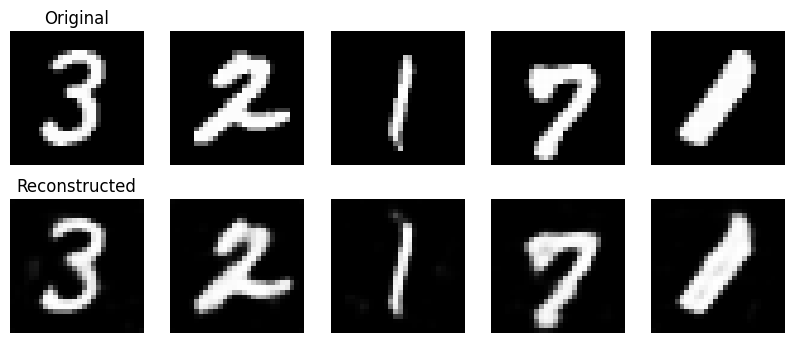

In [18]:
def visualize_reconstructions(model, num_images=5):
    transform = transforms.Compose([transforms.ToTensor()])
    test_loader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST(root="./data", train=False, transform=transform, download=True),
        batch_size=num_images, shuffle=True
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    images, _ = next(iter(test_loader))
    images = images.to(device)
    with torch.no_grad():
        recon_images, _ = model(images)

    images = images.cpu().numpy().squeeze()
    recon_images = recon_images.cpu().numpy().squeeze()

    fig, axes = plt.subplots(2, num_images, figsize=(10, 4))
    for i in range(num_images):
        axes[0, i].imshow(images[i], cmap="gray")
        axes[1, i].imshow(recon_images[i], cmap="gray")
        axes[0, i].axis("off")
        axes[1, i].axis("off")

    axes[0, 0].set_title("Original")
    axes[1, 0].set_title("Reconstructed")
    plt.show()


visualize_reconstructions(model)